#Linear Kalman Filter assignment

Build a signal f(t) defined in the interval [0,10] as

f(t) = atn + sin(bt)

with a and b sampled uniformly in [10,20] and n sampled uniformly between 2, 3, and 4. Add Guassian noise to the sampled version of this signal. Build models in which you assume the function has constant derivative and constant second derivative. Run a Linear Kalman Filter describing the results you obtain when varying the amount of added noise and the process noise covariance matrix.

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

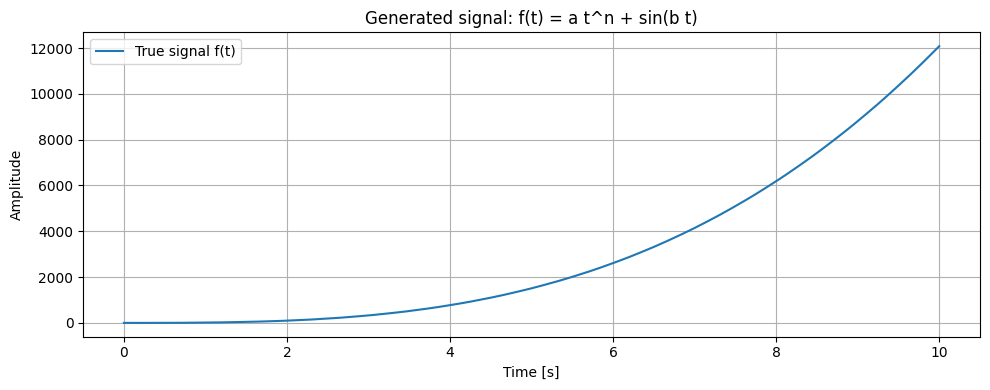

In [80]:
# signal
T = 10.0
dt = 0.05
t = np.arange(0, T+dt, dt)

a = np.random.uniform(10, 20)
b = np.random.uniform(10, 20)
n = np.random.choice([2,3,4])
F = a * (t**n) + np.sin(b*t)

plt.figure(figsize=(10,4))
plt.plot(t, F, label='True signal f(t)', color='C0')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Generated signal: f(t) = a t^n + sin(b t)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [81]:
def add_noise(signal, noise_std):
    """Add Gaussian noise to the signal"""
    return signal + np.random.normal(0, noise_std, len(signal))

In [82]:
# Constant Velocity (First Derivative)
def setup_constant_velocity_kalman(dt, process_noise_scale, measurement_noise):
    """Setup Kalman filter for constant velocity model"""
    
    # State: [position, velocity]
    transition_matrix = np.array([[1, dt],
                                  [0, 1]])
    
    observation_matrix = np.array([[1, 0]])  # Only position is observed
    
    # Process noise covariance - tuned for constant velocity model
    process_noise = process_noise_scale * np.array([[dt**3/3, dt**2/2],
                                                    [dt**2/2, dt]])
    
    # Measurement noise
    observation_noise = np.array([[measurement_noise**2]])
    
    # Initial state and covariance
    initial_state_mean = np.array([0, 0])
    initial_state_covariance = np.eye(2)
    
    kf = KalmanFilter(
        transition_matrices=transition_matrix,
        observation_matrices=observation_matrix,
        transition_covariance=process_noise,
        observation_covariance=observation_noise,
        initial_state_mean=initial_state_mean,
        initial_state_covariance=initial_state_covariance
    )
    
    return kf

In [83]:
# Constant Acceleration (Second Derivative)
def setup_constant_acceleration_kalman(dt, process_noise_scale, measurement_noise):
    """Setup Kalman filter for constant acceleration model using pykalman"""
    
    # State: [position, velocity, acceleration]
    transition_matrix = np.array([[1, dt, dt**2/2],
                                  [0, 1, dt],
                                  [0, 0, 1]])
    
    observation_matrix = np.array([[1, 0, 0]])  # Only position is observed
    
    # Process noise covariance - tuned for constant acceleration model
    process_noise = process_noise_scale * np.array([[dt**5/20, dt**4/8, dt**3/6],
                                                    [dt**4/8, dt**3/3, dt**2/2],
                                                    [dt**3/6, dt**2/2, dt]])
    
    # Measurement noise
    observation_noise = np.array([[measurement_noise**2]])
    
    # Initial state and covariance
    initial_state_mean = np.array([0, 0, 0])
    initial_state_covariance = np.eye(3)
    
    kf = KalmanFilter(
        transition_matrices=transition_matrix,
        observation_matrices=observation_matrix,
        transition_covariance=process_noise,
        observation_covariance=observation_noise,
        initial_state_mean=initial_state_mean,
        initial_state_covariance=initial_state_covariance
    )
    
    return kf

In [84]:
def apply_kalman_smooth(kf, measurements):
    """Return smoothed state means; fallback to filtered means on error."""
    return kf.smooth(measurements)[0]


In [85]:
def apply_kalman_filter(kf, measurements):
    """Apply Kalman filter without smoothing"""
    return kf.filter(measurements)[0]

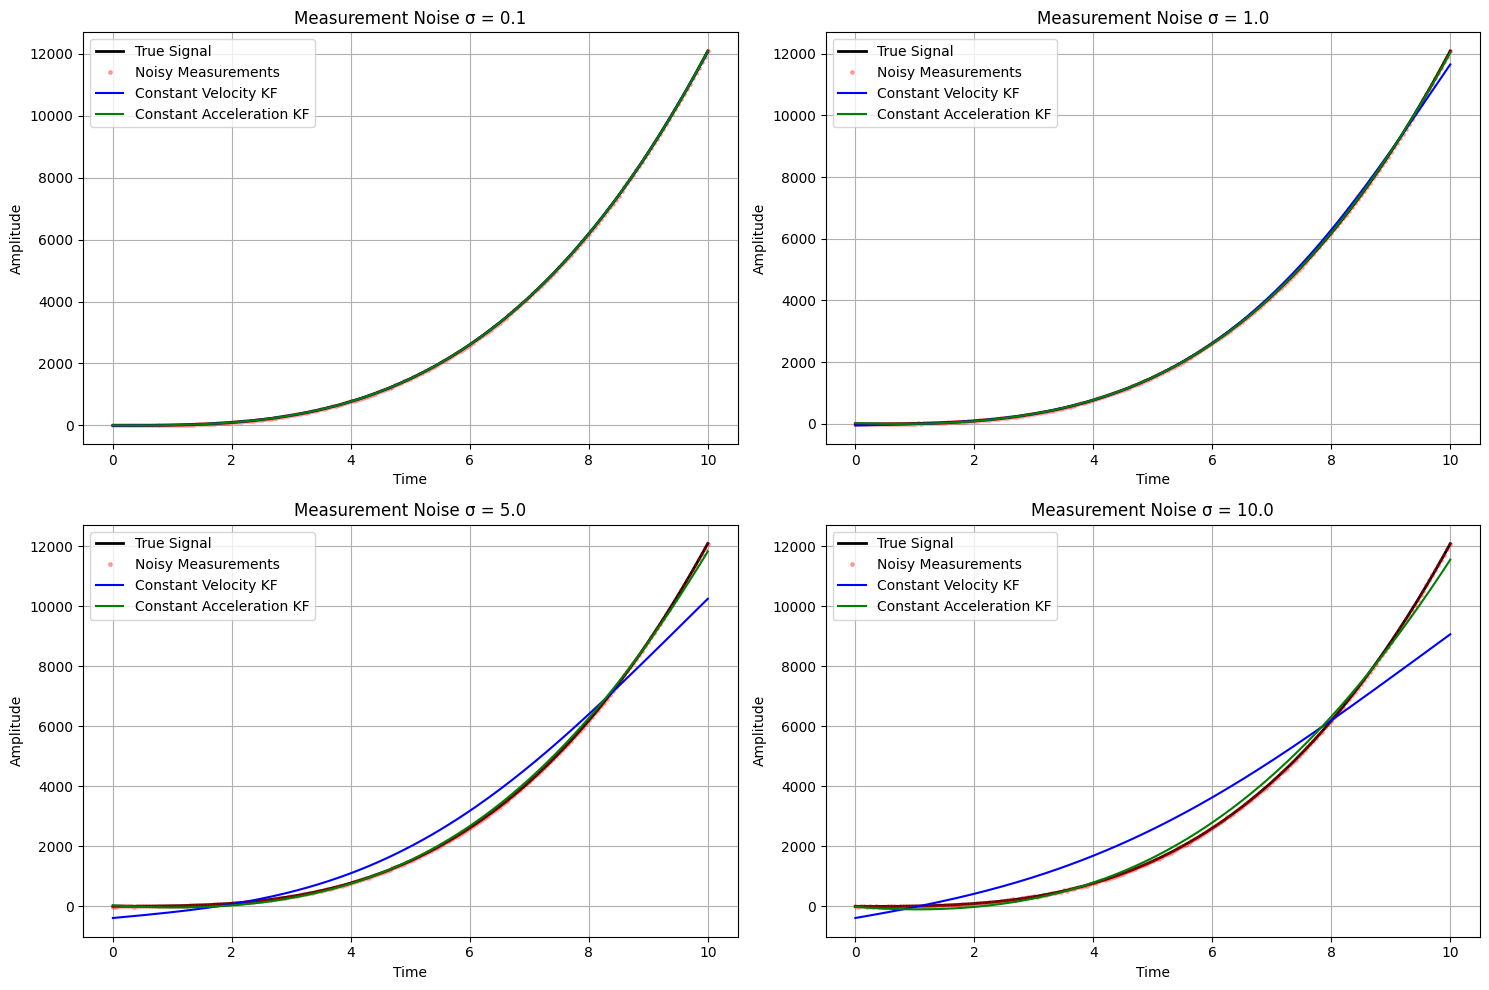

In [ ]:
#Varying Measurement Noise
# Experiment with varying measurement noise levels
noise_levels = [0.1, 1.0, 5.0, 10.0]
process_noise_scale = 0.1
    
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
    
for i, noise_std in enumerate(noise_levels):
    # Add noise to signal
    x_noisy = add_noise(F, noise_std)
        
    # Apply both filters
    kf_velocity = setup_constant_velocity_kalman(dt, process_noise_scale, noise_std)
    kf_acceleration = setup_constant_acceleration_kalman(dt, process_noise_scale, noise_std)
        
    estimates_vel = apply_kalman_smooth(kf_velocity, x_noisy)
    estimates_acc = apply_kalman_smooth(kf_acceleration, x_noisy)
        
    # Extract position estimates
    pos_estimates_vel = estimates_vel[:, 0]
    pos_estimates_acc = estimates_acc[:, 0]
        
    # Plot results
    ax = axes[i]
    ax.plot(t, F, 'k-', label='True Signal', linewidth=2)
    ax.plot(t, x_noisy, 'r.', label='Noisy Measurements', alpha=0.3, markersize=5)
    ax.plot(t, pos_estimates_vel, 'b-', label='Constant Velocity KF', linewidth=1.5)
    ax.plot(t, pos_estimates_acc, 'g-', label='Constant Acceleration KF', linewidth=1.5)
    ax.set_title(f'Measurement Noise σ = {noise_std}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.legend()
    ax.grid(True)
    
plt.tight_layout()
plt.show()

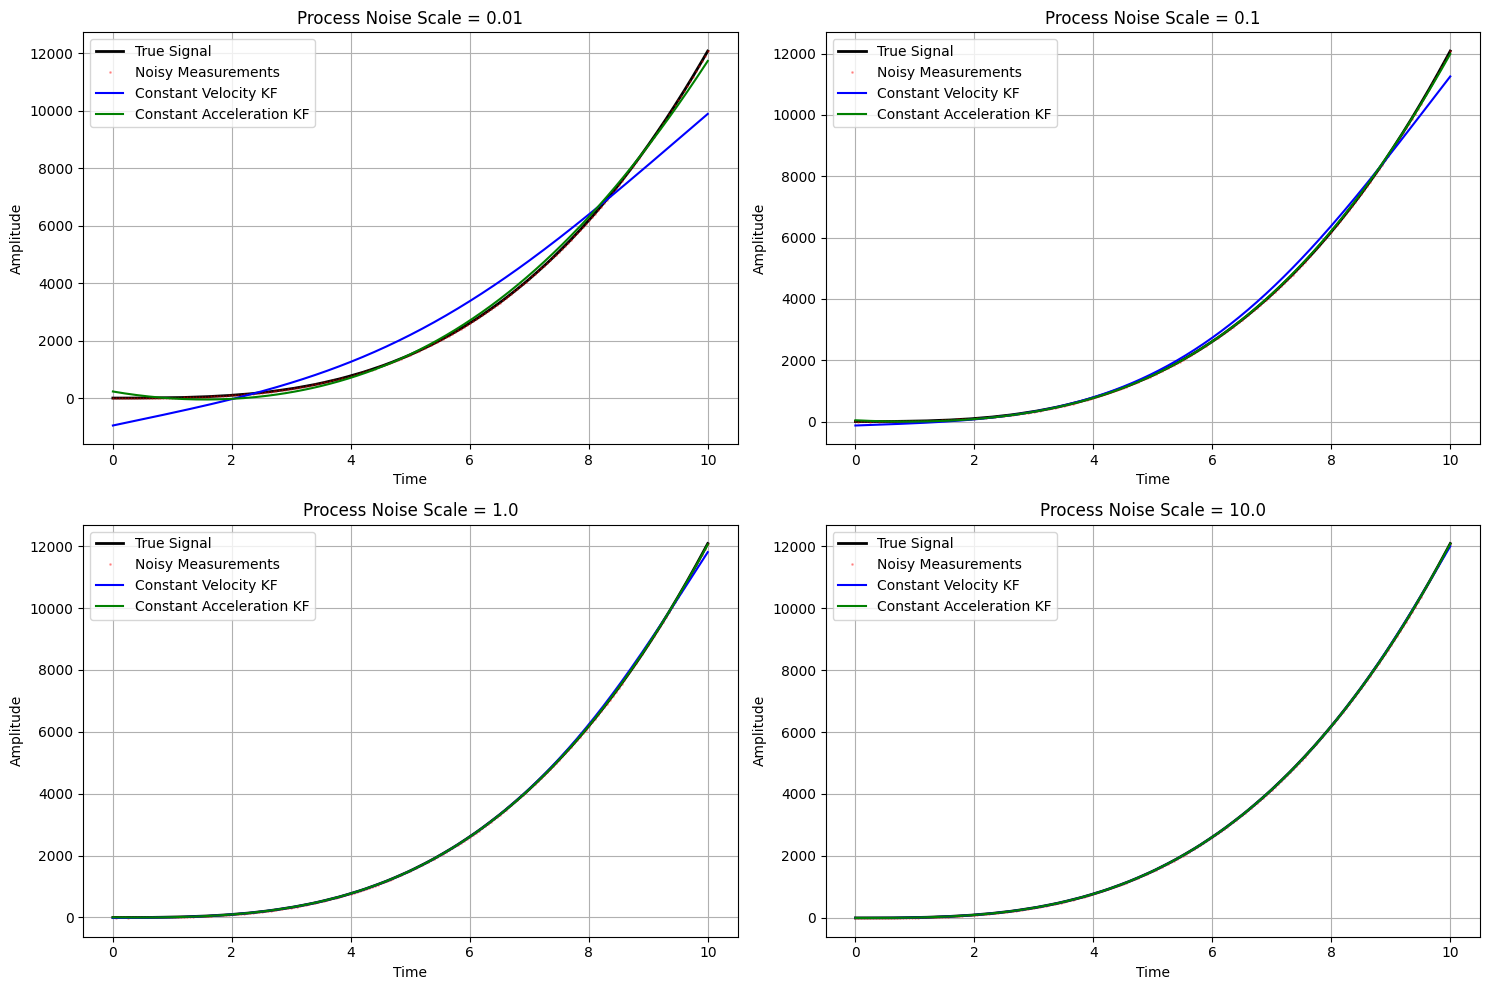

In [ ]:
# Experiment with varying process noise levels
measurement_noise_std = 2.0
process_noise_scales = [0.01, 0.1, 1.0, 10.0]
    
x_noisy = add_noise(F, measurement_noise_std)
    
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
    
for i, process_noise_scale in enumerate(process_noise_scales):
    # Apply both filters
    kf_velocity = setup_constant_velocity_kalman(dt, process_noise_scale, measurement_noise_std)
    kf_acceleration = setup_constant_acceleration_kalman(dt, process_noise_scale, measurement_noise_std)
        
    estimates_vel = apply_kalman_smooth(kf_velocity, x_noisy)
    estimates_acc = apply_kalman_smooth(kf_acceleration, x_noisy)
        
        # Extract position estimates
    pos_estimates_vel = estimates_vel[:, 0]
    pos_estimates_acc = estimates_acc[:, 0]
        
     # Plot results
    ax = axes[i]
    ax.plot(t, F, 'k-', label='True Signal', linewidth=2)
    ax.plot(t, x_noisy, 'r.', label='Noisy Measurements', alpha=0.3, markersize=2)
    ax.plot(t, pos_estimates_vel, 'b-', label='Constant Velocity KF', linewidth=1.5)
    ax.plot(t, pos_estimates_acc, 'g-', label='Constant Acceleration KF', linewidth=1.5)
    ax.set_title(f'Process Noise Scale = {process_noise_scale}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.legend()
    ax.grid(True)
    
plt.tight_layout()
plt.show()


In [88]:
# Performance Metrics
def calculate_metrics(true_signal, estimated_signal):
    """Calculate performance metrics"""
    mse = np.mean((true_signal - estimated_signal)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(true_signal - estimated_signal))
    return rmse, mae

# Quantitative Analysis
def quantitative_analysis():
    """Perform quantitative analysis of filter performance"""
    measurement_noises = [0.5, 1.0, 2.0, 5.0]
    process_noises = [0.01, 0.1, 1.0]
    
    results = {}
    
    for meas_noise in measurement_noises:
        x_noisy = add_noise(F, meas_noise)
        
        for proc_noise in process_noises:
            # Constant Velocity Model
            kf_vel = setup_constant_velocity_kalman(dt, proc_noise, meas_noise)
            estimates_vel = apply_kalman_smooth(kf_vel, x_noisy)
            rmse_vel, mae_vel = calculate_metrics(F, estimates_vel[:, 0])
            
            # Constant Acceleration Model
            kf_acc = setup_constant_acceleration_kalman(dt, proc_noise, meas_noise)
            estimates_acc = apply_kalman_smooth(kf_acc, x_noisy)
            rmse_acc, mae_acc = calculate_metrics(F, estimates_acc[:, 0])
            
            key = f"meas_{meas_noise}_proc_{proc_noise}"
            results[key] = {
                'velocity_rmse': rmse_vel,
                'velocity_mae': mae_vel,
                'acceleration_rmse': rmse_acc,
                'acceleration_mae': mae_acc
            }
    
    return results

print("Performing Quantitative Analysis")
results = quantitative_analysis()

# Print key results
print("\nKey Performance Results:")
print("Measurement Noise | Process Noise | Vel RMSE | Acc RMSE | Improvement")
print("-" * 75)
for key, metrics in list(results.items())[:8]:
    parts = key.split('_')
    meas_noise = parts[1]
    proc_noise = parts[3]
    improvement = ((metrics['velocity_rmse'] - metrics['acceleration_rmse']) / metrics['velocity_rmse']) * 100
    print(f"{meas_noise:16} | {proc_noise:13} | {metrics['velocity_rmse']:8.3f} | {metrics['acceleration_rmse']:8.3f} | {improvement:6.1f}%")


Performing Quantitative Analysis

Key Performance Results:
Measurement Noise | Process Noise | Vel RMSE | Acc RMSE | Improvement
---------------------------------------------------------------------------
0.5              | 0.01          |  137.317 |   19.463 |   85.8%
0.5              | 0.1           |   34.328 |    5.045 |   85.3%
0.5              | 1.0           |    8.463 |    1.313 |   84.5%
1.0              | 0.01          |  323.270 |   51.045 |   84.2%
1.0              | 0.1           |   79.044 |   10.142 |   87.2%
1.0              | 1.0           |   19.588 |    2.421 |   87.6%
2.0              | 0.01          |  693.746 |  113.854 |   83.6%
2.0              | 0.1           |  180.942 |   21.293 |   88.2%
